<a href="https://colab.research.google.com/github/tiagoandresvaz/covid_19/blob/master/COVID_19_Outbreak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE30338](https://jckantor.github.io/CBE30338)
by Jeffrey Kantor (jeff at nd.edu).
Text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode). Code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<p><a href="https://colab.research.google.com/drive/1ddb_0swsq9MRKyHrzflCzeF8Tqqmp24H#scrollTo=0lBOtduur4Ps"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Modeling and Control of a Campus COVID-19 Outbreak

The following cell simulates a COVID-19 outbreak in campus population of size N starting with one infectious case.  The following parameter values for a standard SEIR model were selected from values given in the recent survey by Boldog, et al. (2020).

| Parameter |  Symbol  | Typical |
| :------- | :-- | :-----------: |
| Reproduction number | $R_0$ | 2.4 |
| Incubation period (days)| $\tau_{incubation}$ | 5.1
| Infectious period (days) | $\tau_{infectious}$ | 3.3
| Campus population | $N$ | 20,000 
| Initial number exposed | $n$ | 10
| Mitigation by social distancing | $u$ | 0.2
| Start of social distancing following exposure (weeks) | $t_{sd}$ | 2

To run the model, adjust the sliders below, then click the run arrow that appears in the left marging. The charts will automatically update when the sliders are readjusted.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


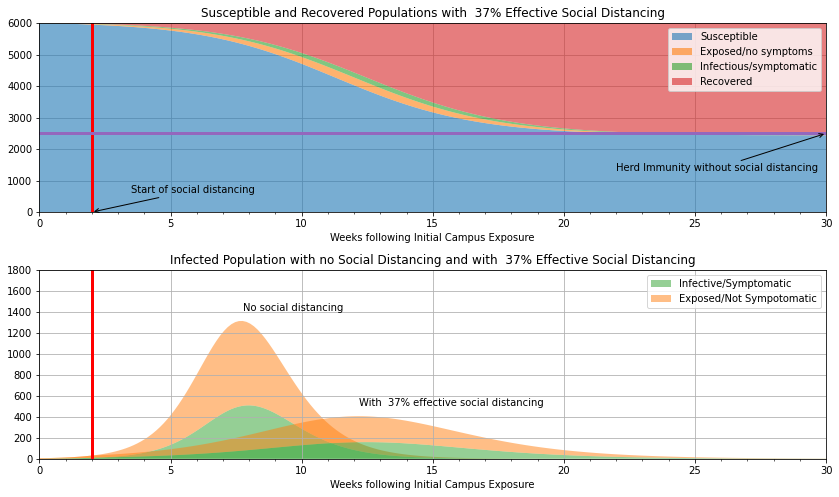

In [ ]:
#@title SEIR Model with Social Distancing { run: "auto" }
#@markdown 
#@markdown Reproduction number
R0 = 2.7 #@param {type:"slider", min:0.9, max:5, step:0.1}
#@markdown Disease periods in days
t_incubation = 5.1 #@param {type:"slider", min:1, max:14, step:0.1}
t_infective = 4 #@param {type:"slider", min:1, max:14, step:0.1}
#@markdown Population Size
N = 6000 #@param {type:"slider", min:1000, max:350000, step: 1000}
#@markdown Initial number exposed
n = 6 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Start of social distancing following exposure (weeks)
t_social_distancing = 2 #@param {type:"slider", min:0, max:30, step:0.1}
#@markdown Effectiveness of social distancing (0 to 100%)
u_social_distancing = 37 #@param {type:"slider", min:0, max:100, step:1}

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns

# initial number of infected and recovered individuals
e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

def step(t):
    return 1 if t >= 7*t_social_distancing else 0

# SEIR model differential equations.
def deriv(x, t, u, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u*step(t)/100)*beta * s * i
    dedt =  (1-u*step(t)/100)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 210, 210)
x_initial = s_initial, e_initial, i_initial, r_initial
s, e, i, r = odeint(deriv, x_initial, t, args=(u_social_distancing, alpha, beta, gamma)).T
s0, e0, i0, r0 = odeint(deriv, x_initial, t, args=(0, alpha, beta, gamma)).T

# plot the data
fig = plt.figure(figsize=(12, 10))
ax = [fig.add_subplot(311, axisbelow=True), 
      fig.add_subplot(312)]

pal = sns.color_palette()

ax[0].stackplot(t/7, N*s, N*e, N*i, N*r, colors=pal, alpha=0.6)
ax[0].set_title('Susceptible and Recovered Populations with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[0].set_xlabel('Weeks following Initial Campus Exposure')
ax[0].set_xlim(0, t[-1]/7)
ax[0].set_ylim(0, N)
ax[0].legend([
    'Susceptible', 
    'Exposed/no symptoms', 
    'Infectious/symptomatic',
    'Recovered'], 
    loc='best')
ax[0].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)
ax[0].plot(np.array([0, t[-1]])/7, [N/R0, N/R0], lw=3, label='herd immunity')
ax[0].annotate("Start of social distancing",
    (t_social_distancing, 0), (t_social_distancing + 1.5, N/10),
    arrowprops=dict(arrowstyle='->'))
ax[0].annotate("Herd Immunity without social distancing",
    (t[-1]/7, N/R0), (t[-1]/7 - 8, N/R0 - N/5),
    arrowprops=dict(arrowstyle='->'))

ax[1].stackplot(t/7, N*i0,N*e0, colors=pal[2:0:-1], alpha=0.5)
ax[1].stackplot(t/7, N*i, N*e, colors=pal[2:0:-1], alpha=0.5)
ax[1].set_title('Infected Population with no Social Distancing and with {0:3.0f}% Effective Social Distancing'.format(u_social_distancing))
ax[1].set_xlim(0, t[-1]/7)
ax[1].set_ylim(0, max(0.3*N, 1.05*max(N*(e + i))))
ax[1].set_xlabel('Weeks following Initial Campus Exposure')
ax[1].legend([
    'Infective/Symptomatic', 
    'Exposed/Not Sympotomatic'],
    loc='upper right')
ax[1].plot(np.array([t_social_distancing, t_social_distancing]), ax[0].get_ylim(), 'r', lw=3)

y0 = N*(e0 + i0)
k0 = np.argmax(y0)
ax[1].annotate("No social distancing", (t[k0]/7, y0[k0] + 100))

y = N*(e + i)
k = np.argmax(y)
ax[1].annotate("With {0:3.0f}% effective social distancing ".format(u_social_distancing), (t[k]/7, y[k] + 100))

for a in ax:
    a.xaxis.set_major_locator(plt.MultipleLocator(5))
    a.xaxis.set_minor_locator(plt.MultipleLocator(1))
    a.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    a.grid(True)

plt.tight_layout()

This Jupyter/Python notebook presents a standard epidimiological model to simulate the outbreak of an infectious disease into a susceptible population. Model parameters are taken from a rapidly evolving scientific literature documenting the global COVID-19 outbreak. Mitigation strategies based on 'social distancing' are incorporated in the model as a control parameter.

The notebook is organized as follows:

1. Background on COVID-19 and the SARS-CoV-2 Coronavirus
1. Sources of Information
1. Introduction to the SEIR Model
1. Social Distancing Strategies
1. Ideas for student projects

## 1. COVID-19 and the SARS-CoV-2 Coronavirus

The purpose of this notebook is to demonstrate the modeling of an infectious epidemic using the latest available data for [COVID-19](https://www.who.int/health-topics/coronavirus), and to provide a framework for evaluating the performance of 'social distancing' and other mitigation strategies. COVID-19 is caused by the human coronavirus SARS-CoV-2. First identified in the 1960's, there are currently four human coronaviruses endemic to populations around the world:

* 229E (alpha coronavirus)
* NL63 (alpha coronavirus)
* OC43 (beta coronavirus)
* HKU1 (beta coronavirus)

These four common coronaviruses cause an upper respiratory disease that can progress to pneumonia. These endemic viruses cause about a quarter of all common colds. Most people will suffer from at least one during their lifetimes.

In recent decades, three additional coronaviruses that normally infect animals have evolved to infect humans. These include:

* MERS-CoV (the beta coronavirus that causes Middle East Respiratory Syndrome, or MERS)
* SARS-CoV (the beta coronavirus that causes severe acute respiratory syndrome, or SARS)
* SARS-CoV-2 (the novel coronavirus that causes coronavirus disease COVID-19)

The last of these, now called SARS-CoV-2, first appeared in December, 2019, at a seafood market in Wuhan (Hubei, China). The rapid spread of SARS-CoV-2 in Wuha and subsequent appearance in other locations around the globe led to declaration of a [global health emergency by the World Health Organization (WHO)](https://www.who.int/emergencies/diseases/novel-coronavirus-2019). 

Countries are mobilizing to track the virus and control new outbreaks. At this stage it is too early to know if efforts to contain the mitigate transmission of the virus will be successful in preventing COVID-19 from becoming a pandemic or, later, evolving into an endemic disease with a global footprint. 

## 2. Sources of Information

General resources on COVID-19

* [Harvard Health](https://www.health.harvard.edu/diseases-and-conditions/coronavirus-resource-center)
* [U.S. Center for Disease Control (CDC)](https://www.cdc.gov/coronavirus/2019-ncov/index.html)

The current status on the global outbreak of COVID-19 can be found at the following links:

* [Coronavirus COVID-19 Global Cases by Johns Hopkins CSSE](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)
* [WHO Novel Coronavirus (COVID-19) Situation](https://experience.arcgis.com/experience/685d0ace521648f8a5beeeee1b9125cd)

The models and data used in this notebook have been extracted from a rapidly emerging and changing literature. Recent papers on COVID-19 can be found at the following links.

* [Cell Press Coronavirus Resource Hub](https://www.cell.com/2019-nCOV)
* [Lancet COVID-19 Resource Centre](https://www.thelancet.com/coronavirus)
* [medRxiv preprint server search on COVID-19](https://www.medrxiv.org/search/COVID-19%20numresults%3A50%20sort%3Apublication-date%20direction%3Adescending)
* [New England Journal of Medicine Coverage on Coronavirus (COVID-19)](https://www.nejm.org/coronavirus)
* [WHO Database of publications on coronavirus disease (COVID-19)](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov)

## 3. Introduction to the SEIR model for epidemics

### Readings

* Keeling, Matt J., and Pejman Rohani. Modeling Infectious Diseases in Humans and Animals. Princeton University Press, 2008. JSTOR, www.jstor.org/stable/j.ctvcm4gk0. Accessed 25 Feb. 2020.
* Pan, Jinhua, et al. "Effectiveness of control strategies for Coronavirus Disease 2019: a SEIR dynamic modeling study." medRxiv (2020). https://www.medrxiv.org/content/10.1101/2020.02.19.20025387v3.full.pdf
* Peng, Liangrong, et al. "Epidemic analysis of COVID-19 in China by dynamical modeling." arXiv preprint arXiv:2002.06563 (2020). https://arxiv.org/abs/2002.06563
* Delamater PL, Street EJ, Leslie TF, Yang YT, Jacobsen KH. Complexity of the basic reproduction number (R0). Emerg Infect Dis. 2019 Jan. Accessed 9 Mar. 2020. https://doi.org/10.3201/eid2501.171901

### SEIR Basics

The SEIR model is deterministic compartment model for the spread of an infectious disease that describes key phenomena encountered in epidemiology. In the SIR model, a population is broken into foir non-overlapping groups corresponding to stages of the disease:

* **Susceptible (S).** The subpopulation susceptible to acquire the disease. 
* **Exposed (E).** The subpopulation that has been been infected with the virus, but not yet in an infective state capable of transmitting the virus to others.
* **Infectious (I).** The subpopulation that has acquired the virus and can infect others.
* **Recovered (R).** The subpopulation that has recovered from infection and presumed to be no longer susceiptible to the disease.

Neglecting demographic processes of birth and death from other causes, and assuming a negligible death rate due to infectious disease at issue, the progression of an epidemic can be modeled by rate processesl

$$\text{Susceptible}
\xrightarrow{(1-u)\frac{\beta S I}{N}} 
\text{Exposed} 
\xrightarrow{\alpha E} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$

The rate processes are modeled as follows.

* $(1-u)\frac{\beta S I}{N}$ is the rate at which susecptible population encounters the infected population resulting in trasmission of the disease. $S$ is the size of the susceptible population. $\beta$ is a the model parameters with units of 1/day. 
* $u$ describes the effectiveness on any public health interventions to control transmission of the disease. $u=0$ corresponds to no effective public health interventions, $u=1$ implies total elimination of disease transmission.
* $\alpha E$ is the rate at which exposed population becomes infective, where $E$ is the size of the exposed population. The average period of time in the exposed state is the incubation period of the disease, and equal to $\frac{1}{\alpha}$.
* $\gamma I$ is the rate at which infected population recovers and becomes resistent to further infection. $I$ is the size of the infective population. The average period of infectious state is $\frac{1}{\gamma}$.

A model for the spread of an infectious disease in a uniform population is given by the deterministic SIR equations

\begin{align*}
\frac{dS}{dt} & = -(1-u)\frac{\beta S I}{N} \\
\frac{dE}{dt} & = (1-u)\frac{\beta S I}{N} - \alpha E \\
\frac{dI}{dt} & = \alpha E - \gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align*} 

The model becomes more generic by working with population fractions rather than raw population counts. To this end, define

\begin{align}
s = \frac{S}{N} \qquad
e = \frac{E}{N} \qquad
i = \frac{I}{N} \qquad
r = \frac{R}{N}
\end{align} 

After substitution, this results in a system of four equations.

\begin{align*}
\frac{ds}{dt} & = -(1-u)\beta s i \\
\frac{de}{dt} & = (1-u)\beta s i - \alpha e \\
\frac{di}{dt} & = \alpha e  - \gamma i \\
\frac{dr}{dt} & = \gamma i
\end{align*}  

where $s + e + i + r = 1$ is an invariant.

### Properties of the SEIR Model

The SEIR model describes key epidemiological phenemena. Here is a brief summary of the key parameters appearing in the SEIR model.

* The parameters $\alpha$, $\beta$ and $\gamma$ have units of inverse time.  
* $\beta$ is the rate constant associated with transmission of the virus.  
* $\alpha$ is rate at which individuals convert from the exposed state to the infectious state. The average period of time is $\tau_{incubate} = \frac{1}{\alpha}$.
* $\gamma$ is the rate of recovery from infections. The associated time constant $\tau_{recovery}=\frac{1}{\gamma}$ is average time to recover from an infection.

The relationships of rate constants to time constants can be summaried as

\begin{align}
\tau_{incubate} = \frac{1}{\alpha} \qquad
\tau_{recovery} = \frac{1}{\gamma}
\end{align}

The SEIR model makes key predictions concerning the outbreak and eventual recovery from an epidemic. These are summarized as follows: 

* The infectious population grows only if $\beta s > \gamma$, that is the rate of infection is greater than the rate of recovery.
* The ratio $R_0 = \frac{\beta}{\gamma}$ is the "Basic Reproduction Number". $R_0$ describes the transmissability or contagiousness of an infectious disease. 
* $R_0$ is the average number of people acquiring the virus from an infected individual in an otherwise completely susceptible population. 
* The infectious population can grow only if $R_0 s > 1$. If $s=1$, then $R_0 > 1$ is sufficient for growth of the infectious population.
* The infected population, that is number of people in the subpopulations E and I, decreases if $s R_0 < 1$ or, equivalently, $s < \frac{1}{R_0}$.
* The population has 'herd immunity' when a sufficient number of individuals are immune to the virus. Under this condition, an outbreak may lead to new cases, but the size of the infected population always decreases. This condition is achieved when the fraction of susceptibles is less than $\frac{1}{R_0}$.

## 4. Social Distancing Strategies

The lack of a vaccine reduces the options for controlling the COVID-19 outbreak. Current efforts are focused on '[social distancing](https://www.cdc.gov/coronavirus/2019-ncov/community/guidance-ihe-response.html)' designed to reduce transmission of the virus from individuals in the infective state to susceptible individuals. Social distancing has the following goals:
* Reduce the cumulative number of individuals infected with the virus.
* Slow progress of any outbreak enough to introduce other mitigation strategies.
* Reduce strain on health care services.

Campus strategies for social distancing might include:

* Replace large section courses with streaming lectures. Close the largest lecture halls for the remainder of the term.
* Bring food to the dorms rather than the dorms to food.
* Locate an area to isolate infectious students, and quarantine students, faculty, and staff with potential exposure.
* Promoting rigorous public hygiene. 

* The addition of an exposed population compartment slows the outbreak and reduces the impact on health services, but doesn't reduce the number of people ultimately infected by the disease.

* What are the campus policy implications of these results?

Social distancing has several beneficial effects:

* Slows down the progress of the epidemic.
* Seduces the fraction of the population infected at any point in time, thereby reducing strain on health care resources.
* Reduces the number of individuals ultimately experiencing the disease. For a disease with a non-zero mortaility, this saves lives.

## 5. Additional Modeling Opportunities.

This notebook was originally prepared as a lecture for [CBE 30338 Chemical Process Control](http://jckantor.github.io/CBE30338/) taught at the University of Notre Dame. Students in the course are encouraged to develop their own models to test alternative hypotheses. The following papers are suggested starting points.

### Power Law Kinetics

The SEIR model is a well-known and widely used deterministic model for epidemiology. An underlying assumption of the SEIR model is a rate law proportional to the product of susceptible and infectious sub-populations that predicts exponential growth in the early phases of an epidemic. A network model would leads to power law kinetics that may be a better fit to observed data.

* Ziff, Robert M., and Anna L. Ziff. "Fractal kinetics of COVID-19 pandemic." medRxiv (2020). https://www.medrxiv.org/content/10.1101/2020.02.16.20023820v1

### Transportation

The simulation model presented in this notebook assumes single, homegeneous sub-populations of susceptible, exposed, infectious, and recovered individuals. The notebook model could be extended to geographically distributed populations by adding the transportation terms outlined, for example, in the following papers.

* Peng, Liangrong, et al. "Epidemic analysis of COVID-19 in China by dynamical modeling." arXiv preprint arXiv:2002.06563 (2020).  https://arxiv.org/abs/2002.06563

* Wu, Joseph T., Kathy Leung, and Gabriel M. Leung. "Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study." The Lancet (2020). https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext

* Chinazzi, Matteo, et al. "The effect of travel restrictions on the spread of the 2019 novel coronavirus (2019-nCoV) outbreak." medRxiv (2020). https://science.sciencemag.org/content/early/2020/03/05/science.aba9757

### Now-casting with Limited Testing Data

Reporting only cases that have been confirmed by postive test results undercounts the number of exposed and infected individuals. Is it possible to construct a procedure to better estimate the actual count of exposed and infected individuals from limited test data?

* Bedford, Trevor. Cryptic transmission of novel coronavirus revealed by genomic epidemiology. Accessed 4 Mar 2020. https://bedford.io/blog/ncov-cryptic-transmission/

* Tuite, Ashleigh R., and David N. Fisman. "Reporting, Epidemic Growth, and Reproduction Numbers for the 2019 Novel Coronavirus (2019-nCoV) Epidemic." Annals of Internal Medicine (2020). https://annals.org/aim/fullarticle/2760912

* Wood, Graeme. "Iran Has Far More Coronavirus Cases Than It Is Letting On." The Atlantic, 9 March 2020. https://www.theatlantic.com/ideas/archive/2020/03/irans-coronavirus-problem-lot-worse-it-seems/607663/